In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedGroupKFold
from sklearn.metrics import roc_auc_score ,accuracy_score
from imblearn.over_sampling import SMOTE  # Synthetic Minority Oversampling Technique

# Models
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
 

# Model Tuning 
from sklearn.model_selection import GridSearchCV

# Warnings (to keep notebook clean)
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns',None)

In [2]:
plt.style.available  # viewing styling catogries for visualizing 

['Solarize_Light2',
 '_classic_test_patch',
 '_mpl-gallery',
 '_mpl-gallery-nogrid',
 'bmh',
 'classic',
 'dark_background',
 'fast',
 'fivethirtyeight',
 'ggplot',
 'grayscale',
 'seaborn-v0_8',
 'seaborn-v0_8-bright',
 'seaborn-v0_8-colorblind',
 'seaborn-v0_8-dark',
 'seaborn-v0_8-dark-palette',
 'seaborn-v0_8-darkgrid',
 'seaborn-v0_8-deep',
 'seaborn-v0_8-muted',
 'seaborn-v0_8-notebook',
 'seaborn-v0_8-paper',
 'seaborn-v0_8-pastel',
 'seaborn-v0_8-poster',
 'seaborn-v0_8-talk',
 'seaborn-v0_8-ticks',
 'seaborn-v0_8-white',
 'seaborn-v0_8-whitegrid',
 'tableau-colorblind10']

In [3]:
plt.style.use('seaborn-v0_8-darkgrid')  # applying style 

# Loading Data for Analysing

In [4]:
test = pd.read_csv("test.csv")
train = pd.read_csv("train.csv")
sub = pd.read_csv("sample_submission.csv")

# Defineing functions 

In [5]:
# basic eda function
def explore_data(dataset):
    print(f'Shape       : {dataset.shape}')
    print('x'*90)
    print(f'Columns     : {dataset.columns}')
    print('x'*90)
    print(f'Data types  :{dataset.dtypes}')
    print('x'*90)
    dataset.info()
    print('x'*90)

In [6]:
# models in a dictionary
models = {
    "LightGBM": LGBMClassifier(),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
    "CatBoost": CatBoostClassifier(verbose=0)  # silent mode
}

# function to evaluate models
def fit_and_score(models, X_train, X_test, y_train, y_test, seed=42):
    np.random.seed(seed)
    model_scores = {}

    for name, model in models.items():
        model.fit(X_train, y_train)
        model_scores[name] = model.score(X_test, y_test)

    return model_scores

# EDA on train

In [7]:
train.head(10)

,id,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,0,42,technician,married,secondary,no,7,no,no,cellular,25,aug,117,3,-1,0,unknown,0
1,1,38,blue-collar,married,secondary,no,514,no,no,unknown,18,jun,185,1,-1,0,unknown,0
2,2,36,blue-collar,married,secondary,no,602,yes,no,unknown,14,may,111,2,-1,0,unknown,0
3,3,27,student,single,secondary,no,34,yes,no,unknown,28,may,10,2,-1,0,unknown,0
4,4,26,technician,married,secondary,no,889,yes,no,cellular,3,feb,902,1,-1,0,unknown,1
5,5,24,admin.,single,secondary,no,1882,yes,no,cellular,20,apr,1010,3,-1,0,unknown,0
6,6,39,blue-collar,married,secondary,no,0,no,no,telephone,21,nov,90,1,-1,0,unknown,0
7,7,50,admin.,single,secondary,no,1595,no,no,telephone,31,jul,49,25,-1,0,unknown,0
8,8,46,blue-collar,married,primary,no,1463,no,no,cellular,4,aug,50,1,-1,0,unknown,0
9,9,39,management,divorced,tertiary,no,25,yes,no,cellular,8,may,119,1,-1,0,unknown,0


In [8]:
explore_data(train)

Shape       : (750000, 18)
xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx
Columns     : Index(['id', 'age', 'job', 'marital', 'education', 'default', 'balance',
       'housing', 'loan', 'contact', 'day', 'month', 'duration', 'campaign',
       'pdays', 'previous', 'poutcome', 'y'],
      dtype='object')
xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx
Data types  :id            int64
age           int64
job          object
marital      object
education    object
default      object
balance       int64
housing      object
loan         object
contact      object
day           int64
month        object
duration      int64
campaign      int64
pdays         int64
previous      int64
poutcome     object
y             int64
dtype: object
xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 750000 entries, 0 to 749999
Dat

In [9]:
train.describe()

,id,age,balance,day,duration,campaign,pdays,previous,y
count,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000
mean,374999.500000,40.926395,1204.067397,16.117209,256.229144,2.577008,22.412733,0.298545,0.120651
std,216506.495284,10.098829,2836.096759,8.250832,272.555662,2.718514,77.319998,1.335926,0.325721
min,0.000000,18.000000,-8019.000000,1.000000,1.000000,1.000000,-1.000000,0.000000,0.000000
25%,187499.750000,33.000000,0.000000,9.000000,91.000000,1.000000,-1.000000,0.000000,0.000000
50%,374999.500000,39.000000,634.000000,17.000000,133.000000,2.000000,-1.000000,0.000000,0.000000
75%,562499.250000,48.000000,1390.000000,21.000000,361.000000,3.000000,-1.000000,0.000000,0.000000
max,749999.000000,95.000000,99717.000000,31.000000,4918.000000,63.000000,871.000000,200.000000,1.000000


In [10]:
train.isnull().sum() # checking missing values

id           0
age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
y            0
dtype: int64

In [11]:
train.duplicated().sum()  # checking for duplicate values

0

## Target distribution 

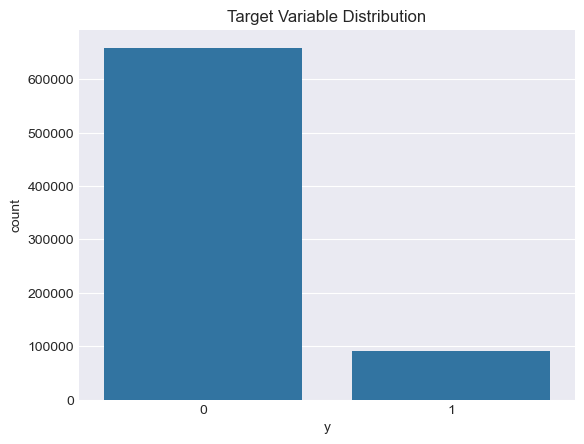

In [12]:
sns.countplot(x='y', data=train)
plt.title("Target Variable Distribution")
plt.show()

In [13]:
train['y'].value_counts()   # frequency table of y

y
0    659512
1     90488
Name: count, dtype: int64

In [14]:
cat_cols = train.select_dtypes(include='object').columns
print("Categorical Features:", cat_cols.tolist())

Categorical Features: ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome']


# EDA on test

In [15]:
test.head(10)

,id,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome
0,750000,32,blue-collar,married,secondary,no,1397,yes,no,unknown,21,may,224,1,-1,0,unknown
1,750001,44,management,married,tertiary,no,23,yes,no,cellular,3,apr,586,2,-1,0,unknown
2,750002,36,self-employed,married,primary,no,46,yes,yes,cellular,13,may,111,2,-1,0,unknown
3,750003,58,blue-collar,married,secondary,no,-1380,yes,yes,unknown,29,may,125,1,-1,0,unknown
4,750004,28,technician,single,secondary,no,1950,yes,no,cellular,22,jul,181,1,-1,0,unknown
5,750005,43,management,divorced,unknown,no,3025,no,no,cellular,21,jul,89,2,-1,0,unknown
6,750006,26,services,single,primary,no,3511,no,no,cellular,29,jan,816,3,-1,0,unknown
7,750007,60,management,married,tertiary,no,79,no,yes,cellular,9,jul,707,1,-1,0,unknown
8,750008,45,blue-collar,married,primary,no,16,no,no,telephone,6,feb,173,1,-1,0,unknown
9,750009,41,management,married,tertiary,no,46,no,no,cellular,18,aug,657,4,-1,0,unknown


In [16]:
explore_data(test)

Shape       : (250000, 17)
xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx
Columns     : Index(['id', 'age', 'job', 'marital', 'education', 'default', 'balance',
       'housing', 'loan', 'contact', 'day', 'month', 'duration', 'campaign',
       'pdays', 'previous', 'poutcome'],
      dtype='object')
xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx
Data types  :id            int64
age           int64
job          object
marital      object
education    object
default      object
balance       int64
housing      object
loan         object
contact      object
day           int64
month        object
duration      int64
campaign      int64
pdays         int64
previous      int64
poutcome     object
dtype: object
xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250000 entries, 0 to 249999
Data columns (total 17 colum

In [17]:
test.describe()

,id,age,balance,day,duration,campaign,pdays,previous
count,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000
mean,874999.500000,40.932332,1197.426352,16.116068,255.342260,2.573548,22.280028,0.303728
std,72168.927986,10.081613,2741.520699,8.258509,271.404326,2.709661,76.915879,1.384574
min,750000.000000,18.000000,-8019.000000,1.000000,3.000000,1.000000,-1.000000,0.000000
25%,812499.750000,33.000000,0.000000,9.000000,91.000000,1.000000,-1.000000,0.000000
50%,874999.500000,39.000000,631.000000,17.000000,133.000000,2.000000,-1.000000,0.000000
75%,937499.250000,48.000000,1389.000000,21.000000,353.000000,3.000000,-1.000000,0.000000
max,999999.000000,95.000000,98517.000000,31.000000,4918.000000,58.000000,871.000000,150.000000


In [18]:
test.isnull().sum() # checking for null

id           0
age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
dtype: int64

In [19]:
test.duplicated().sum()  # checking for duplicates

0

In [20]:
cat_cols = train.select_dtypes(include='object').columns
print("Categorical Features:", cat_cols.tolist())

Categorical Features: ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome']


# Visualization of train Data

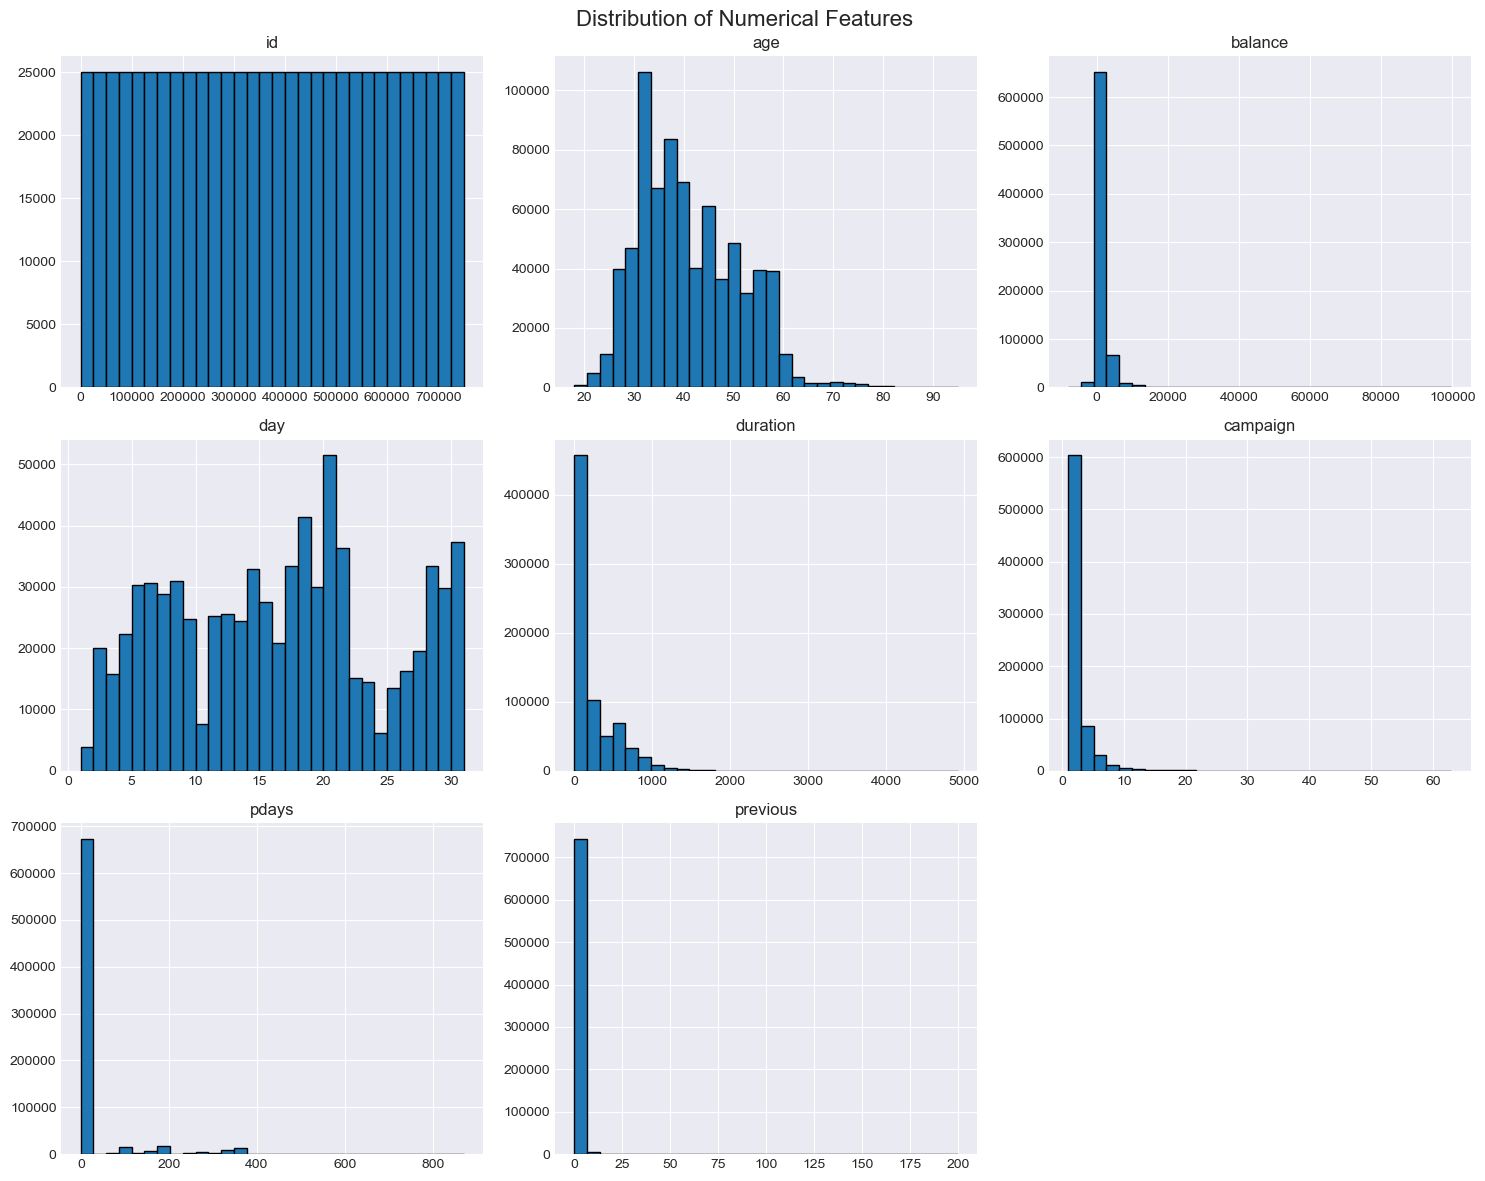

In [21]:
num_col = train.select_dtypes(include=np.number).columns.tolist()
num_col.remove('y') # target removed

train[num_col].hist(figsize=(15,12),bins=30 , edgecolor='black')
plt.suptitle("Distribution of Numerical Features",fontsize= 16)
plt.tight_layout()
plt.show()

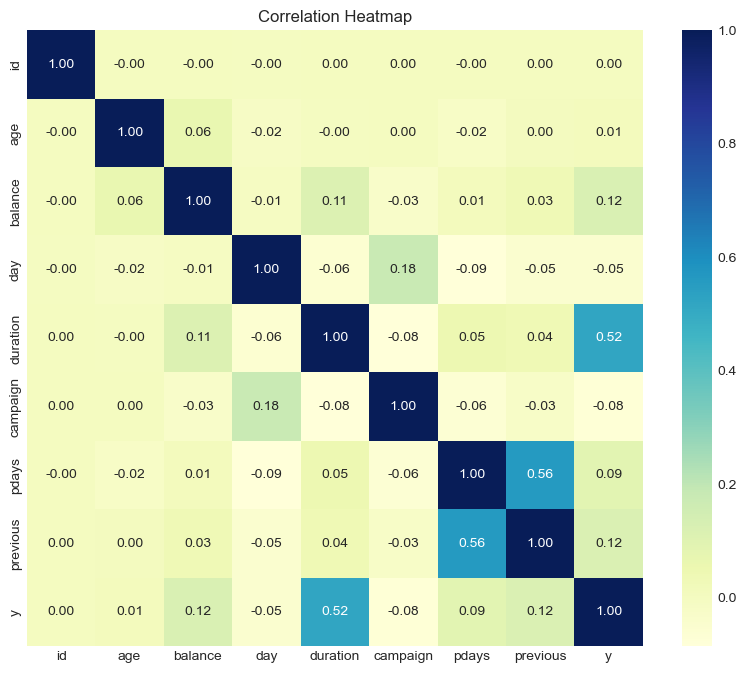

y           1.000000
duration    0.519283
balance     0.122513
previous    0.119552
pdays       0.089277
age         0.009523
id          0.000615
day        -0.049625
campaign   -0.075829
Name: y, dtype: float64


In [22]:
num_col = train.select_dtypes(include=np.number).columns.tolist() # with target

corr = train[num_col].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="YlGnBu", square=True)
plt.title("Correlation Heatmap")
plt.show()

# Correlation with target
corr_target = train[num_col].corr()['y'].sort_values(ascending=False)
print(corr_target)

# Cleaning train

In [23]:
# drop unwanted columns
train.drop('id',axis=1,inplace=True)

## Encoding

In [24]:
train.select_dtypes(include='object').columns

Index(['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact',
       'month', 'poutcome'],
      dtype='object')

In [25]:
for col in cat_cols:
    print(f"{col}: {train[col].nunique()} unique values")

job: 12 unique values
marital: 3 unique values
education: 4 unique values
default: 2 unique values
housing: 2 unique values
loan: 2 unique values
contact: 3 unique values
month: 12 unique values
poutcome: 4 unique values


In [26]:
le = LabelEncoder()
#  For Binary Columns:

binary_cols = ['default', 'housing', 'loan']
for col in binary_cols:
    train[col] = le.fit_transform(train[col])

In [27]:
#For Ordinal Column (education, optionally month):

# Manual mapping
education_order = {'unknown': 0, 'primary': 1, 'secondary': 2, 'tertiary': 3}
train['education'] = train['education'].map(education_order)

# Optional month mapping
month_order = {'jan':1, 'feb':2, 'mar':3, 'apr':4, 'may':5, 'jun':6,
               'jul':7, 'aug':8, 'sep':9, 'oct':10, 'nov':11, 'dec':12}
train['month'] = train['month'].map(month_order)

In [28]:
# For Non-Ordinal Columns (multi-category):

multi_cat_cols = ['job', 'marital', 'contact', 'poutcome']
train = pd.get_dummies(train, columns=multi_cat_cols, drop_first=True , dtype=int)

In [29]:
train.head()

,age,education,default,balance,housing,loan,day,month,duration,campaign,pdays,previous,y,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,job_unknown,marital_married,marital_single,contact_telephone,contact_unknown,poutcome_other,poutcome_success,poutcome_unknown
0,42,2,0,7,0,0,25,8,117,3,-1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1
1,38,2,0,514,0,0,18,6,185,1,-1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1
2,36,2,0,602,1,0,14,5,111,2,-1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1
3,27,2,0,34,1,0,28,5,10,2,-1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,1
4,26,2,0,889,1,0,3,2,902,1,-1,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1


# Cleaning Test data

## Encoding

In [30]:
cat_cols = test.select_dtypes(include='object').columns

In [31]:
for col in cat_cols:
    print(f"{col}: {test[col].nunique()} unique values")

job: 12 unique values
marital: 3 unique values
education: 4 unique values
default: 2 unique values
housing: 2 unique values
loan: 2 unique values
contact: 3 unique values
month: 12 unique values
poutcome: 4 unique values


In [32]:
le = LabelEncoder()
#  For Binary Columns:

binary_cols = ['default', 'housing', 'loan']
for col in binary_cols:
    test[col] = le.fit_transform(test[col])

In [33]:
#For Ordinal Column (education, optionally month):

# Manual mapping
education_order = {'unknown': 0, 'primary': 1, 'secondary': 2, 'tertiary': 3}
test['education'] = test['education'].map(education_order)

# Optional month mapping
month_order = {'jan':1, 'feb':2, 'mar':3, 'apr':4, 'may':5, 'jun':6,
               'jul':7, 'aug':8, 'sep':9, 'oct':10, 'nov':11, 'dec':12}
test['month'] =test['month'].map(month_order)

In [34]:
# For Non-Ordinal Columns (multi-category):

multi_cat_cols = ['job', 'marital', 'contact', 'poutcome']
test = pd.get_dummies(test, columns=multi_cat_cols, drop_first=True , dtype=int)

In [35]:
test.head(10)

,id,age,education,default,balance,housing,loan,day,month,duration,campaign,pdays,previous,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,job_unknown,marital_married,marital_single,contact_telephone,contact_unknown,poutcome_other,poutcome_success,poutcome_unknown
0,750000,32,2,0,1397,1,0,21,5,224,1,-1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1
1,750001,44,3,0,23,1,0,3,4,586,2,-1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1
2,750002,36,1,0,46,1,1,13,5,111,2,-1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1
3,750003,58,2,0,-1380,1,1,29,5,125,1,-1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1
4,750004,28,2,0,1950,1,0,22,7,181,1,-1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1
5,750005,43,0,0,3025,0,0,21,7,89,2,-1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1
6,750006,26,1,0,3511,0,0,29,1,816,3,-1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1
7,750007,60,3,0,79,0,1,9,7,707,1,-1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1
8,750008,45,1,0,16,0,0,6,2,173,1,-1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1
9,750009,41,3,0,46,0,0,18,8,657,4,-1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1


# Training the model

In [37]:
train.head()

,age,education,default,balance,housing,loan,day,month,duration,campaign,pdays,previous,y,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,job_unknown,marital_married,marital_single,contact_telephone,contact_unknown,poutcome_other,poutcome_success,poutcome_unknown
0,42,2,0,7,0,0,25,8,117,3,-1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1
1,38,2,0,514,0,0,18,6,185,1,-1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1
2,36,2,0,602,1,0,14,5,111,2,-1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1
3,27,2,0,34,1,0,28,5,10,2,-1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,1
4,26,2,0,889,1,0,3,2,902,1,-1,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1


In [41]:
# spliting  the data in to target and features
X = train.drop('y',axis=1)
y = train['y']

In [42]:
# spltting into test and train
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2)

In [50]:
scores = fit_and_score(models,X_train,X_test,y_train,y_test)

[LightGBM] [Info] Number of positive: 72283, number of negative: 527717
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.113101 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1015
[LightGBM] [Info] Number of data points in the train set: 600000, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.120472 -> initscore=-1.987971
[LightGBM] [Info] Start training from score -1.987971


In [51]:
scores

{'LightGBM': 0.9344, 'XGBoost': 0.9337, 'CatBoost': 0.9359466666666667}

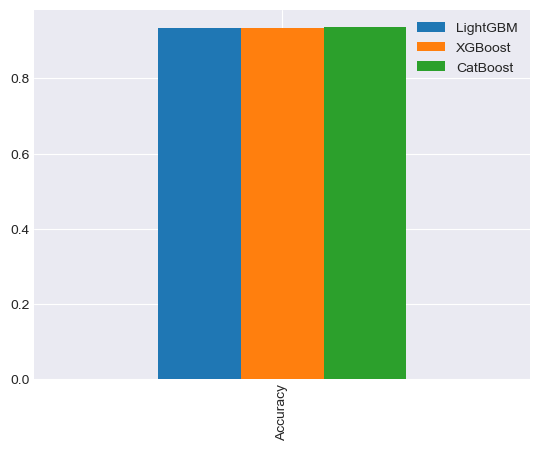

In [42]:
model_compare = pd.DataFrame(scores,index=['Accuracy'])
model_compare.plot.bar()
plt.show()

### Discription : 
You will see that all three models give relitively similar accuracy ~93%   but the highest accurracy of cat boost : 93.59466666666667 

# Cat boost Model tuning

In [43]:
# Base model
model = CatBoostClassifier(verbose=0, random_state=42)

# Reduced and balanced grid for faster and optimal search
param_grid = {
    'iterations': [100, 200],
    'learning_rate': [0.05, 0.1],       # Removed 0.01 to speed up
    'depth': [4, 6],                    # Removed 8 to reduce combinations
    'l2_leaf_reg': [3, 5],
    'border_count': [32, 64]
}

# Grid Search
grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring='accuracy',
    cv=3,
    n_jobs=-1,
    verbose=1  # Show progress
)

# Fit model
grid_search.fit(X_train, y_train)

# Predict and evaluate
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

# Output
print("✅ Best Parameters:", grid_search.best_params_)
print("✅ Test Accuracy after GridSearchCV tuning:", accuracy)

Fitting 3 folds for each of 32 candidates, totalling 96 fits
✅ Best Parameters: {'border_count': 64, 'depth': 6, 'iterations': 200, 'l2_leaf_reg': 5, 'learning_rate': 0.1}
✅ Test Accuracy after GridSearchCV tuning: 0.9310333333333334


In [45]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42)

final_model = CatBoostClassifier(
    border_count=64,
    depth=6,
    iterations=200,
    l2_leaf_reg=5,
    learning_rate=0.1,
    random_state=42,
    verbose=0  # Keeps output clean
)

# Train the model
final_model.fit(X_train, y_train)

# Make predictions
y_pred = final_model.predict(X_test)

# Evaluate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Final Test Accuracy:", accuracy)

Final Test Accuracy: 0.9305933333333334


In [47]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(random_state=42)
model = rfc.fit(X_train, y_train)
model.score(X_test, y_test)

0.9305466666666666

Less then cat Boost !!

# Traning the train data set

In [36]:
# splitting data into  train 
X_train = train.drop('y',axis=1)
y_train = train['y']
X_test = test.drop('id',axis=1)

cb =  CatBoostClassifier(verbose=0,random_state=42)
model = cb.fit(X_train,y_train)

y_pred = model.predict(X_test)

In [37]:
sub.head()

,id,y
0,750000,0.5
1,750001,0.5
2,750002,0.5
3,750003,0.5
4,750004,0.5


In [38]:
test.head()

,id,age,education,default,balance,housing,loan,day,month,duration,campaign,pdays,previous,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,job_unknown,marital_married,marital_single,contact_telephone,contact_unknown,poutcome_other,poutcome_success,poutcome_unknown
0,750000,32,2,0,1397,1,0,21,5,224,1,-1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1
1,750001,44,3,0,23,1,0,3,4,586,2,-1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1
2,750002,36,1,0,46,1,1,13,5,111,2,-1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1
3,750003,58,2,0,-1380,1,1,29,5,125,1,-1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1
4,750004,28,2,0,1950,1,0,22,7,181,1,-1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1


In [40]:
result = pd.DataFrame({'id' : test['id'],
                      'y' : y_pred})

In [41]:
result.head(10)

,id,y
0,750000,0
1,750001,0
2,750002,0
3,750003,0
4,750004,0
5,750005,0
6,750006,0
7,750007,0
8,750008,0
9,750009,0


In [47]:
result.to_csv('submission.csv',index=False)